In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline


# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

raw = pd.read_csv('../../../../../datasets/paris_listings.csv')
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url':'url',
    'property_type':'숙소_특징',
    'number_of_reviews_ltm':'12개월_리뷰수',
    'has_availability':'예약가능여부'
})


# 슈퍼호스트, 리뷰수 결측치 제거
print(f"처음 df : {len(df)}")
df = df[~df['슈퍼호스트'].isnull()]
print(f"슈퍼호스트 제거 : {len(df)}")
df = df[df['리뷰수']>2]
print(f"리뷰수 제거 : {len(df)}")

# 숙소가격 null값 제거
df= df[~df['숙소_가격'].isnull()]

#가격 앞 통화기호 제거
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 유형 제거 
df = df[(df['숙소_유형']=='Entire home/apt') | (df['숙소_유형']=='Private room')]
print(f"숙소_유형 제거 : {len(df)}")

# 12개월 리뷰수 0 개 제거ㅋ 
df = df[df['12개월_리뷰수']!=0]
print(f"12개월_리뷰수 0개 제거 : {len(df)}")

# 욕실수, 침실수, 침대수 null값 제거
df = df.dropna(subset=['욕실수', '침실수', '침대수'])
print(f"욕실수, 침실수, 침대수 제거 후 : {len(df)}")

# 리뷰  null값 제거
df = df.dropna(subset=['숙소_정확성_리뷰점수','숙소_청결도_리뷰점수','숙소_체크인_리뷰점수','숙소_소통_리뷰점수','숙소_위치_리뷰점수','숙소_가격_리뷰점수'])
print(f"리뷰 결측치 제거 후 : {len(df)}")


# 예약 가능여부 f 버리기
df = df.dropna(subset='예약가능여부')
print(f"예약가능여부 : {len(df)}")



from urllib.parse import urlparse, urlunparse, parse_qs, urlencode

# URL에 쿼리 파라미터를 추가하는 함수
def modify_url(url, params):
    url_parts = list(urlparse(url))
    query = dict(parse_qs(url_parts[4]))
    query.update(params)
    url_parts[4] = urlencode(query, doseq=True)
    return urlunparse(url_parts)

# 파라미터 추가
params = {'locale': 'en'}

# 각 URL을 순회하면서 수정
df['url'] = [modify_url(url, params) for url in df['url']]

처음 df : 84397
슈퍼호스트 제거 : 84306
리뷰수 제거 : 47841
숙소_유형 제거 : 34280
12개월_리뷰수 0개 제거 : 31052
욕실수, 침실수, 침대수 제거 후 : 30997
리뷰 결측치 제거 후 : 30997
예약가능여부 : 30990


In [8]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import random
import re
from datetime import datetime, timedelta

def convert_date(date_str):
    today = datetime.now()
    match_ago = re.search(r"(\d+) (week|day)s? ago", date_str)
    if match_ago:
        number, unit = match_ago.groups()
        number = int(number)
        if 'week' in unit:
            date = today - timedelta(weeks=number)
        elif 'day' in unit:
            date = today - timedelta(days=number)
        return date.strftime("%Y-%m-%d")
    match_month_year = re.search(r"(\w+) \d{4}", date_str)
    if match_month_year:
        return datetime.strptime(match_month_year.group(), "%B %Y").strftime("%Y-%m-%d")
    return "없음"

def airbnb_reviews(url):
    random_sec = random.uniform(1, 5)
    chrome_driver_path = 'C:/chromedriver-win64/chromedriver.exe'
    chrome_service = Service(chrome_driver_path)
    options = Options()
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_experimental_option("detach", True)
    driver = webdriver.Chrome(service=chrome_service, options=options)
    driver.set_window_size(1920, 1080)
    driver.get(url)
    time.sleep(random_sec)

    try:
        translation_modal_close_button = WebDriverWait(driver, random_sec).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[aria-label="Close"]'))
        )
        translation_modal_close_button.click()
        time.sleep(1)
    except Exception as e:
        print("번역 모달 창 실패 :", e)

    try:
        review_button = WebDriverWait(driver, random_sec).until(
            EC.element_to_be_clickable((By.XPATH, "//button[contains(text(), 'Show all') and contains(text(), 'reviews')]"))
        )
        review_button.click()
    except Exception as e:
        print("리뷰 버튼 실패 :", e)
        driver.quit()
        return []

    try:
        scroll_panel = WebDriverWait(driver, random_sec).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div[data-testid="pdp-reviews-modal-scrollable-panel"]'))
        )
    except Exception as e:
        print("리뷰 모달창 실패 :", e)
        driver.quit()
        return []

    driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight;", scroll_panel)
    time.sleep(1)

    reviews = []
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    review_container = soup.find('div', {'data-testid': 'pdp-reviews-modal-scrollable-panel'})
    if review_container:
        review_tags = review_container.find_all('span', class_='lrl13de atm_kd_19r6f69_24z95b atm_kd_19r6f69_1xbvphn_1oszvuo dir dir-ltr')
        for i in range(1, len(review_tags) + 1):
            text = review_tags[i-1].text.strip()
            date_elements = driver.find_elements(By.XPATH, f"/html/body/div[9]/div/div/section/div/div/div[2]/div/div[3]/div/div/div/section/div/section/div/div[2]/div[2]/div/div[{i}]/div[1]/div")
            if date_elements:
                dates = [element.text for element in date_elements if element.text.strip() != '']
                dates = [convert_date(date) for date in dates]
                if dates:  
                    reviews.append({'리뷰': text, '리뷰날짜': dates[0]})
                else:
                    reviews.append({'리뷰': text, '리뷰날짜': '날짜 정보 없음'})
            else:
                reviews.append({'리뷰': text, '리뷰날짜': '날짜 정보 없음'})
    driver.quit()

    reviews_df = pd.DataFrame(reviews)
    reviews_df['리뷰날짜'] = pd.to_datetime(reviews_df['리뷰날짜'],errors='coerce', format="%Y-%m-%d")
    filtered_reviews_df = reviews_df[(reviews_df['리뷰날짜'] >= "2024-04-01") & (reviews_df['리뷰날짜'] <= datetime.now())]

    return filtered_reviews_df


df_subset = df[['숙소_id', 'url']]

# 새로운 DataFrame 생성
paris_reviews = pd.DataFrame(columns=['url', '숙소_id', '리뷰', '리뷰날짜'])

# 각 숙소에 대해 리뷰 정보 수집
for index, row in df_subset.iterrows():
    review_data = airbnb_reviews(row['url'])
    if index == 2:
        break
    review_data['url'] = row['url']
    review_data['숙소_id'] = row['숙소_id']
    paris_reviews = pd.concat([paris_reviews, review_data], ignore_index=True)



C:\Users\ciw96\AppData\Local\Temp\ipykernel_19356\841764227.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  paris_reviews = pd.concat([paris_reviews, review_data], ignore_index=True)


In [9]:
paris_reviews.head()

,url,숙소_id,리뷰,리뷰날짜
0,https://www.airbnb.com/rooms/165409?locale=en,165409,"Great apartment, fantastic location.",2024-05-30
1,https://www.airbnb.com/rooms/165409?locale=en,165409,Thank you Gillian for your review. We hope to ...,2024-05-26
2,https://www.airbnb.com/rooms/165409?locale=en,165409,"They were kind and attentive, the location was...",2024-05-12
3,https://www.airbnb.com/rooms/165409?locale=en,165409,The accommodation is located directly in the b...,2024-04-01
4,https://www.airbnb.com/rooms/165409?locale=en,165409,It was lovely ! Thanks so much.,2024-04-01


In [28]:
df.isnull().sum()

숙소_id          0
호스트_id         0
슈퍼호스트          0
숙소_수           0
숙소_지역          0
숙소_유형          0
수용_인원수         0
욕실수            0
침실수            0
침대수            0
편의시설           0
숙소_가격          0
최소_숙박일         0
최대_숙박일         0
리뷰수            0
30일_리뷰수        0
리뷰점수           0
숙소_정확성_리뷰점수    0
숙소_청결도_리뷰점수    0
숙소_체크인_리뷰점수    0
숙소_소통_리뷰점수     0
숙소_위치_리뷰점수     0
숙소_가격_리뷰점수     0
평균_리뷰수         0
url            0
숙소_특징          0
12개월_리뷰수       0
예약가능여부         0
응답률            0
dtype: int64

In [29]:
df.describe()

,숙소_id,호스트_id,숙소_수,수용_인원수,욕실수,침실수,침대수,숙소_가격,최소_숙박일,최대_숙박일,...,리뷰점수,숙소_정확성_리뷰점수,숙소_청결도_리뷰점수,숙소_체크인_리뷰점수,숙소_소통_리뷰점수,숙소_위치_리뷰점수,숙소_가격_리뷰점수,평균_리뷰수,12개월_리뷰수,응답률
count,2.346800e+04,2.346800e+04,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,...,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000,23468.000000
mean,4.217568e+17,1.528003e+08,26.397392,3.320138,1.186871,1.249830,1.798449,194.999616,4.528592,460.928924,...,4.747822,4.788667,4.688623,4.827121,4.847419,4.832996,4.640292,1.724337,16.964249,96.022669
std,4.261658e+17,1.773518e+08,94.201141,1.783909,0.555760,0.951776,1.298154,461.474835,14.382845,450.486195,...,0.250244,0.222788,0.296640,0.209585,0.205200,0.194814,0.266978,1.549166,17.619675,13.856133
min,5.396000e+03,2.626000e+03,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,...,1.400000,2.000000,1.200000,2.200000,1.800000,2.600000,1.400000,0.040000,1.000000,0.000000
25%,2.794599e+07,1.501997e+07,1.000000,2.000000,1.000000,1.000000,1.000000,100.000000,2.000000,30.000000,...,4.640000,4.710000,4.560000,4.770000,4.800000,4.770000,4.510000,0.690000,6.000000,100.000000
50%,5.628659e+17,5.669737e+07,2.000000,3.000000,1.000000,1.000000,1.000000,140.000000,2.000000,365.000000,...,4.820000,4.850000,4.770000,4.890000,4.920000,4.890000,4.700000,1.280000,12.000000,100.000000
75%,8.578770e+17,2.682360e+08,7.000000,4.000000,1.000000,2.000000,2.000000,219.000000,3.000000,1125.000000,...,4.920000,4.940000,4.900000,4.960000,5.000000,4.970000,4.820000,2.270000,21.000000,100.000000
max,1.103697e+18,5.649976e+08,909.000000,16.000000,48.000000,50.000000,77.000000,53239.000000,365.000000,1126.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,37.090000,825.000000,100.000000


# 슈퍼호스트 t f 차이
-슈퍼호스트인데 4.8 이하값 너무 많음

           리뷰점수  숙소_정확성_리뷰점수  숙소_청결도_리뷰점수  숙소_체크인_리뷰점수  숙소_소통_리뷰점수  \
슈퍼호스트                                                                
f      4.667829     4.726701     4.604989     4.779080    4.793205   
t      4.873198     4.885788     4.819706     4.902417    4.932390   

       숙소_위치_리뷰점수  숙소_가격_리뷰점수  
슈퍼호스트                          
f        4.806152    4.563856  
t        4.875068    4.760094  


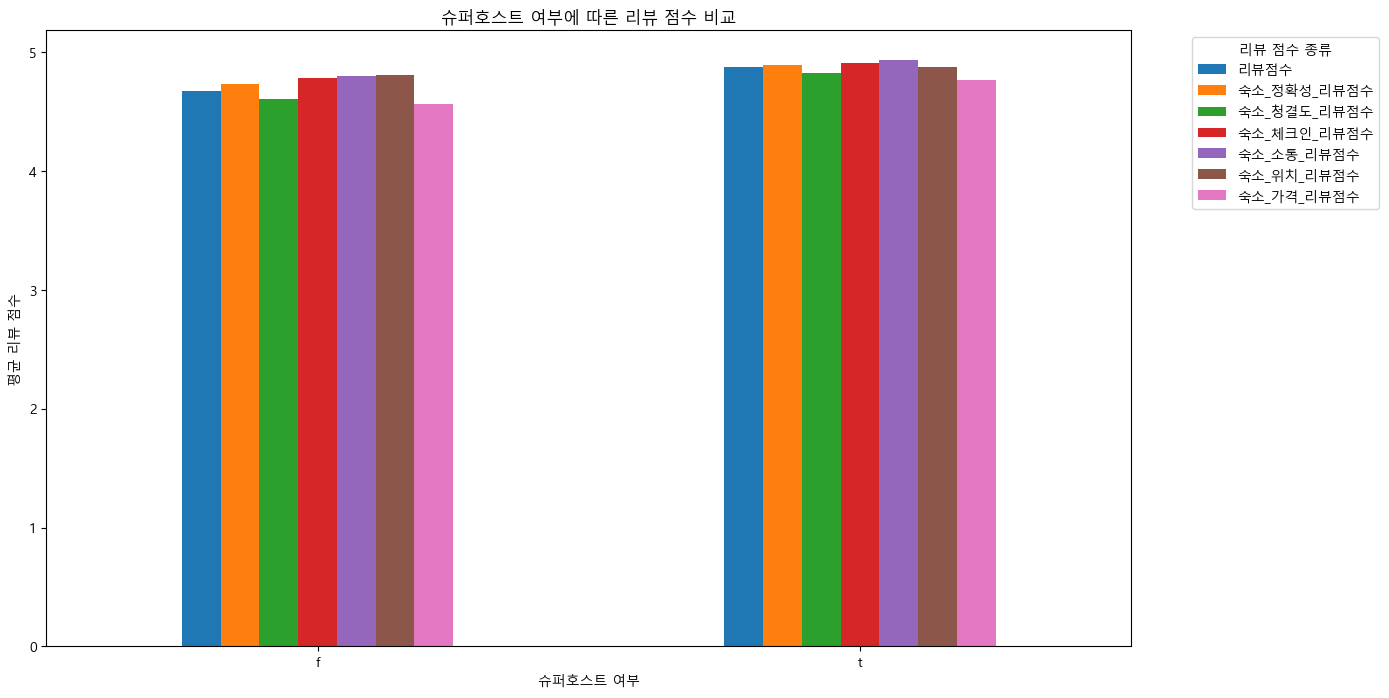

In [30]:
# 슈퍼호스트별로 각 리뷰 점수의 평균을 계산
review_scores_by_type = df.groupby('슈퍼호스트')[[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수']].mean()

# 결과 출력
print(review_scores_by_type)

# 시각화
review_scores_by_type.plot(kind='bar', figsize=(14, 8))
plt.title('슈퍼호스트 여부에 따른 리뷰 점수 비교')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('평균 리뷰 점수')
plt.xticks(rotation=0)
plt.legend(title='리뷰 점수 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


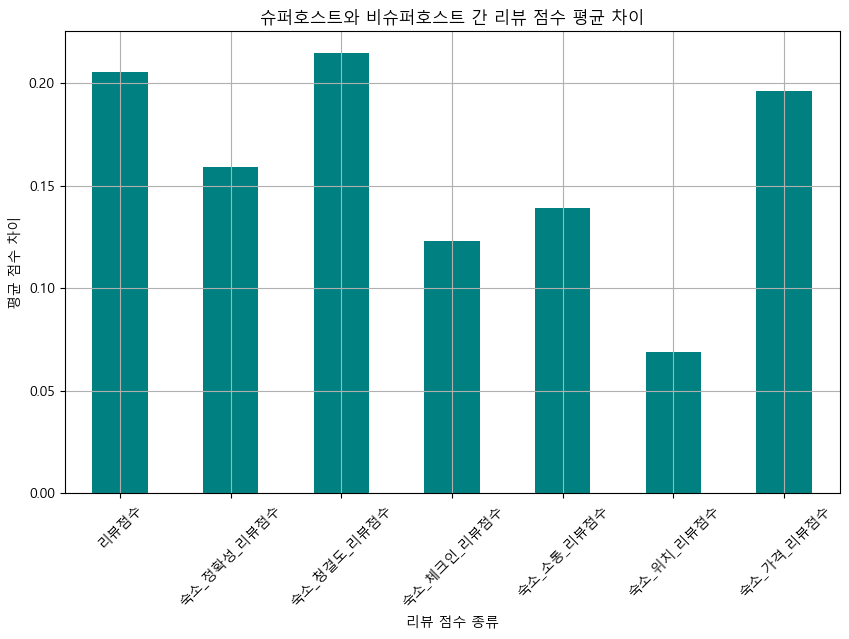

In [31]:
# 슈퍼호스트인 경우와 아닌 경우의 차이 계산
score_diff = review_scores_by_type.diff().iloc[1]

# 차이를 막대 그래프로 표시
score_diff.plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('슈퍼호스트와 비슈퍼호스트 간 리뷰 점수 평균 차이')
plt.xlabel('리뷰 점수 종류')
plt.ylabel('평균 점수 차이')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


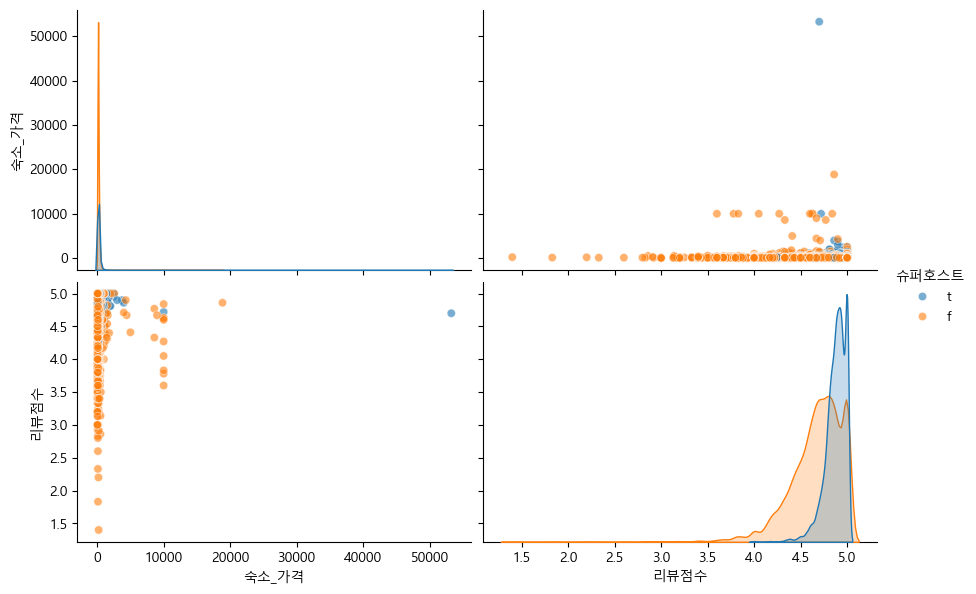

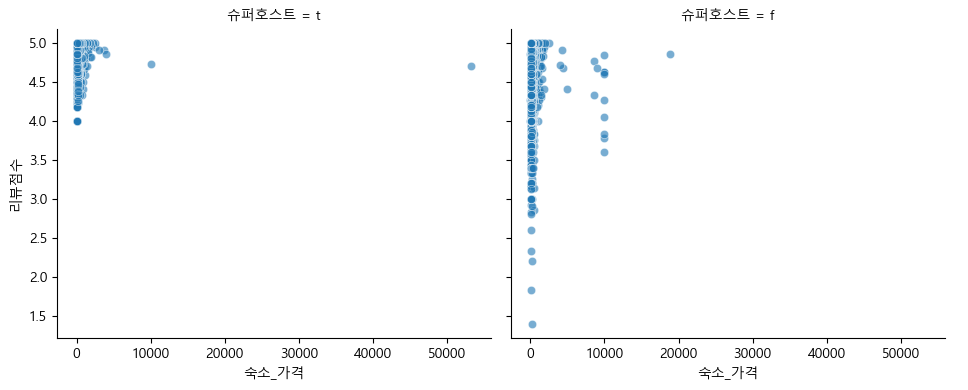

In [32]:
# Seaborn의 Pairplot을 사용하여 슈퍼호스트 여부에 따른 가격과 리뷰 점수의 관계를 그래프로 나타냄
sns.pairplot(df, vars=['숙소_가격', '리뷰점수'], hue='슈퍼호스트', height=3, aspect=1.5, plot_kws={'alpha':0.6})
plt.show()

# FacetGrid를 사용하여 좀 더 구체적인 조건부 플롯을 만들 수 있음
g = sns.FacetGrid(df, col='슈퍼호스트', height=4, aspect=1.2)
g.map(sns.scatterplot, '숙소_가격', '리뷰점수', alpha=0.6)
g.add_legend()
plt.show()

점수로그변환

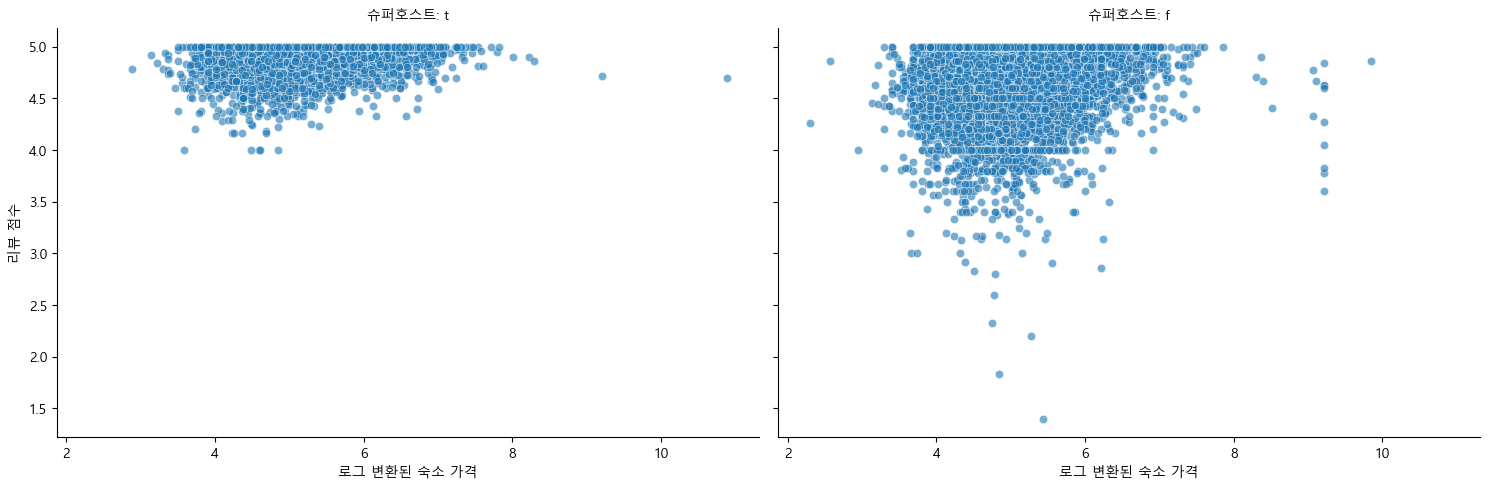

In [33]:
# 로그 변환 적용 전에 0 이상인 데이터만 필터링
df_filtered = df[df['숙소_가격'] > 0]

# 로그 변환 적용
df_filtered['로그_숙소_가격'] = np.log(df_filtered['숙소_가격'])

# 조건부 플롯 생성
g = sns.FacetGrid(df_filtered, col='슈퍼호스트', height=5, aspect=1.5)
g.map(sns.scatterplot, '로그_숙소_가격', '리뷰점수', alpha=0.6)

# 그래프 제목 및 레이블 설정
g.set_titles("슈퍼호스트: {col_name}")
g.set_axis_labels("로그 변환된 숙소 가격", "리뷰 점수")

# 플롯 표시
plt.show()


원래 데이터의 크기: 23468
이상치 제거 후 데이터의 크기: 22852


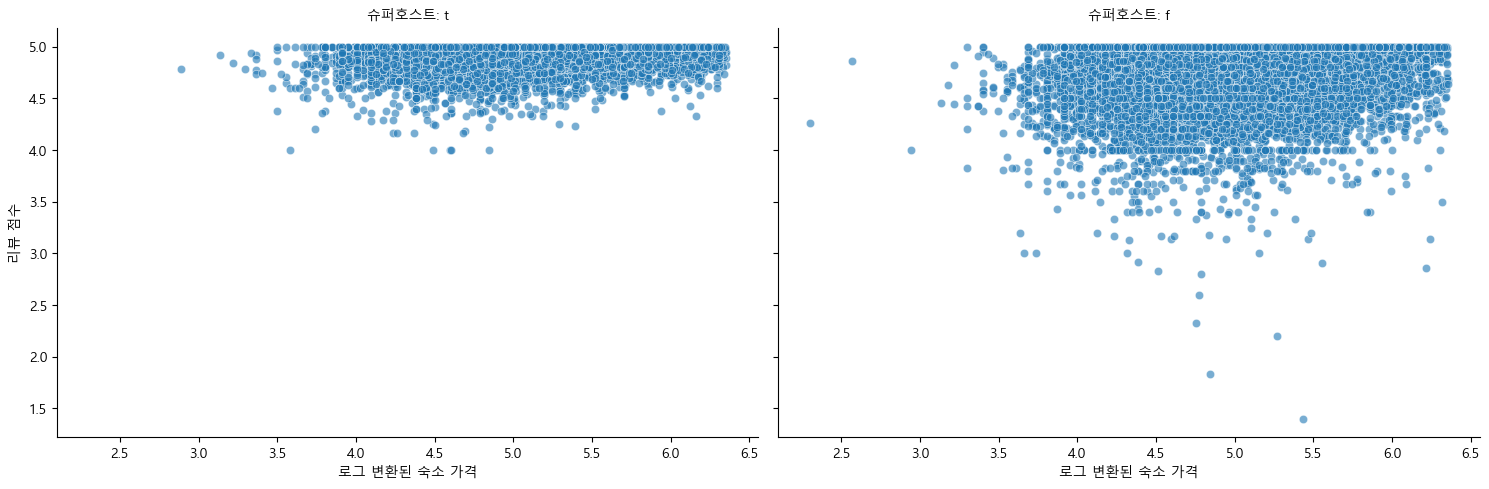

In [34]:
# 사분위수를 계산합니다.
Q1 = df['숙소_가격'].quantile(0.25)
Q3 = df['숙소_가격'].quantile(0.75)
IQR = Q3 - Q1

# 이상치가 아닌 범위를 조정하여 정의합니다.
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

print(f"원래 데이터의 크기: {len(df)}")
# 이상치를 제거합니다.
df = df[(df['숙소_가격'] >= lower_bound) & (df['숙소_가격'] <= upper_bound)]

# 로그 변환을 적용합니다.
df['로그_숙소_가격'] = np.log(df['숙소_가격'])

# 결과 확인
print(f"이상치 제거 후 데이터의 크기: {len(df)}")

# 조건부 플롯을 다시 그립니다.
g = sns.FacetGrid(df, col='슈퍼호스트', height=5, aspect=1.5)
g.map(sns.scatterplot, '로그_숙소_가격', '리뷰점수', alpha=0.6)
g.set_titles("슈퍼호스트: {col_name}")
g.set_axis_labels("로그 변환된 숙소 가격", "리뷰 점수")
plt.show()


In [65]:
print(len(df[(df['슈퍼호스트']=='t') & ((df['리뷰점수']<4.8) | (df['응답률']<90))]))
print(len(df[(df['슈퍼호스트']=='t') & (df['리뷰점수']>=4.8)]))
      

1881
7142


 - 이상헤서 로그변환

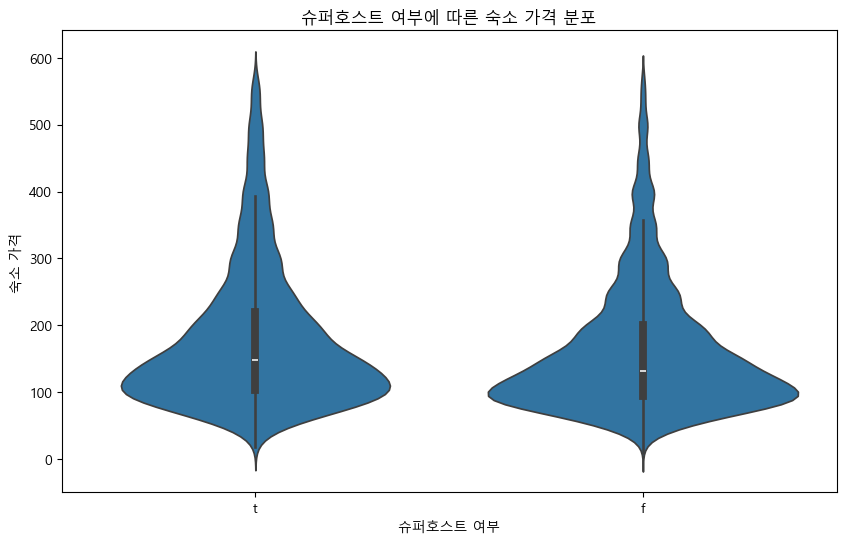

In [35]:
# 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x='슈퍼호스트', y='숙소_가격', data=df)
plt.title('슈퍼호스트 여부에 따른 숙소 가격 분포')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('숙소 가격')
plt.show()


- 슈퍼호스트기 가격에 영향을 준다?

In [36]:
from scipy.stats import mannwhitneyu

# 슈퍼호스트와 비슈퍼호스트의 가격 데이터 추출
superhost_prices = df[df['슈퍼호스트'] == 't']['숙소_가격']
nonsuperhost_prices = df[df['슈퍼호스트'] == 'f']['숙소_가격']

# Mann-Whitney U 테스트 수행
u_stat, p_value = mannwhitneyu(superhost_prices, nonsuperhost_prices, alternative='two-sided')

print("Mann-Whitney U 통계량:", u_stat)
print("P-값:", p_value)


Mann-Whitney U 통계량: 68125169.5
P-값: 4.727722784237536e-38


In [37]:
# 슈퍼호스트 숙소의 가격 중앙값
superhost_median = df[df['슈퍼호스트'] == 't']['숙소_가격'].median()

# 비슈퍼호스트 숙소의 가격 중앙값
nonsuperhost_median = df[df['슈퍼호스트'] == 'f']['숙소_가격'].median()

print("슈퍼호스트 숙소 가격 중앙값:", superhost_median)
print("비슈퍼호스트 숙소 가격 중앙값:", nonsuperhost_median)


슈퍼호스트 숙소 가격 중앙값: 149.0
비슈퍼호스트 숙소 가격 중앙값: 132.0


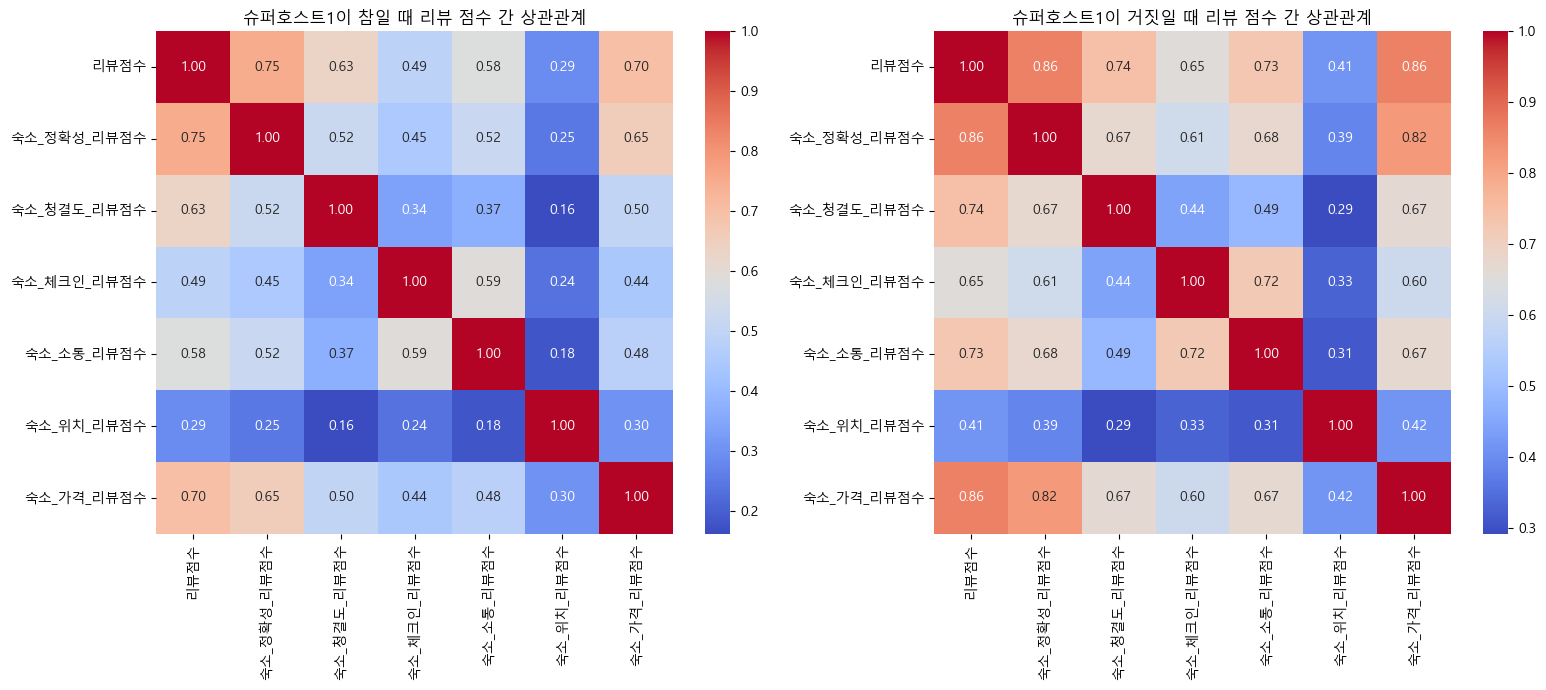

In [38]:
# 관련 리뷰 점수 컬럼 선택
review_scores_data_true = df[df['슈퍼호스트'] == 't'][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

review_scores_data_false = df[df['슈퍼호스트'] == 'f'][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

# 상관계수 계산
correlation_matrix_true = review_scores_data_true.corr()
correlation_matrix_false = review_scores_data_false.corr()

# 히트맵 생성
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)  # 첫 번째 히트맵
sns.heatmap(correlation_matrix_true, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 참일 때 리뷰 점수 간 상관관계')

plt.subplot(1, 2, 2)  # 두 번째 히트맵
sns.heatmap(correlation_matrix_false, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 거짓일 때 리뷰 점수 간 상관관계')

plt.tight_layout()
plt.show()


# 임의로 슈퍼호스트1 변수 추가 
- 리뷰점수4.8 + 응답률 90
- 상관 관계가 많이 이상함

In [39]:
df['슈퍼호스트1'] = (df['리뷰점수'] >= 4.9) & (df['리뷰수']>4)

In [40]:
len(df[df['슈퍼호스트1']==True])

7160

            리뷰점수  숙소_정확성_리뷰점수  숙소_청결도_리뷰점수  숙소_체크인_리뷰점수  숙소_소통_리뷰점수  \
슈퍼호스트1                                                                
False   4.645254     4.714357     4.591066     4.773608    4.792428   
True    4.964735     4.946487     4.891453     4.941177    4.965972   

        숙소_위치_리뷰점수  숙소_가격_리뷰점수  
슈퍼호스트1                          
False     4.796433    4.544855  
True      4.906339    4.843786  


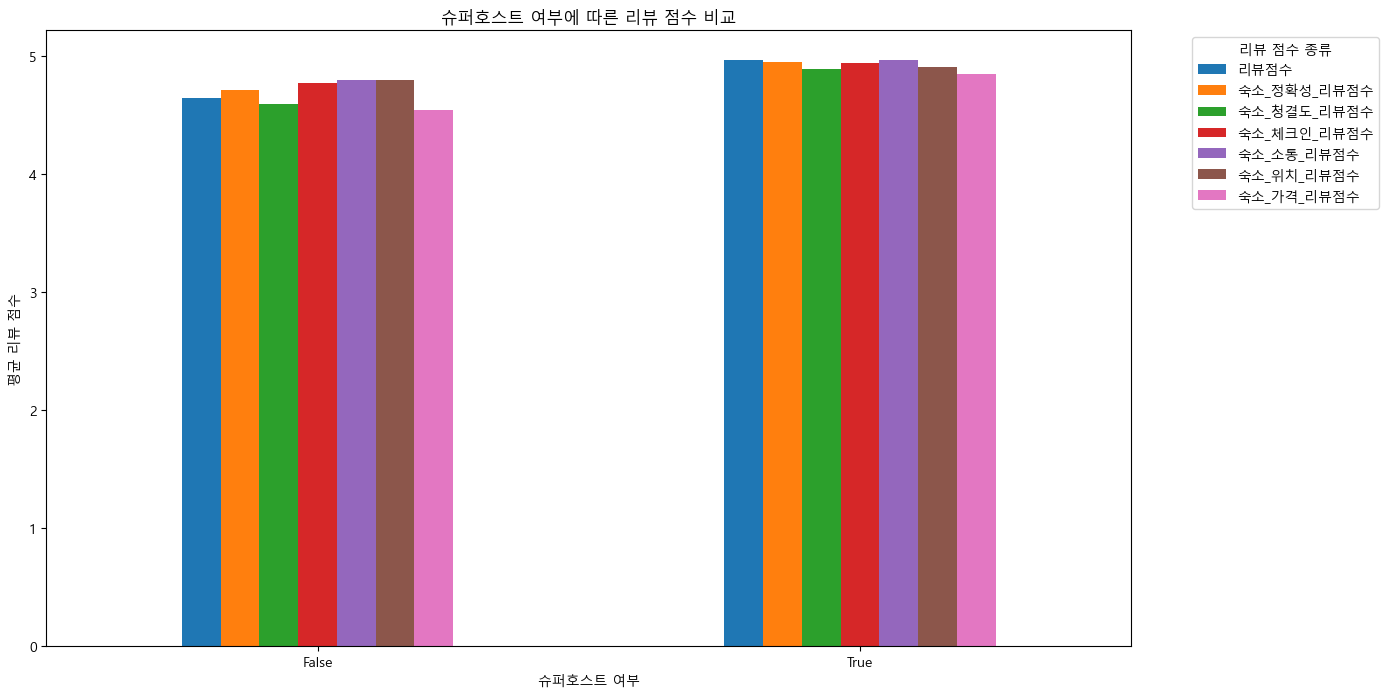

In [41]:
# 슈퍼호스트별로 각 리뷰 점수의 평균을 계산
review_scores_by_type = df.groupby('슈퍼호스트1')[[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수']].mean()

# 결과 출력
print(review_scores_by_type)

# 시각화
review_scores_by_type.plot(kind='bar', figsize=(14, 8))
plt.title('슈퍼호스트 여부에 따른 리뷰 점수 비교')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('평균 리뷰 점수')
plt.xticks(rotation=0)
plt.legend(title='리뷰 점수 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


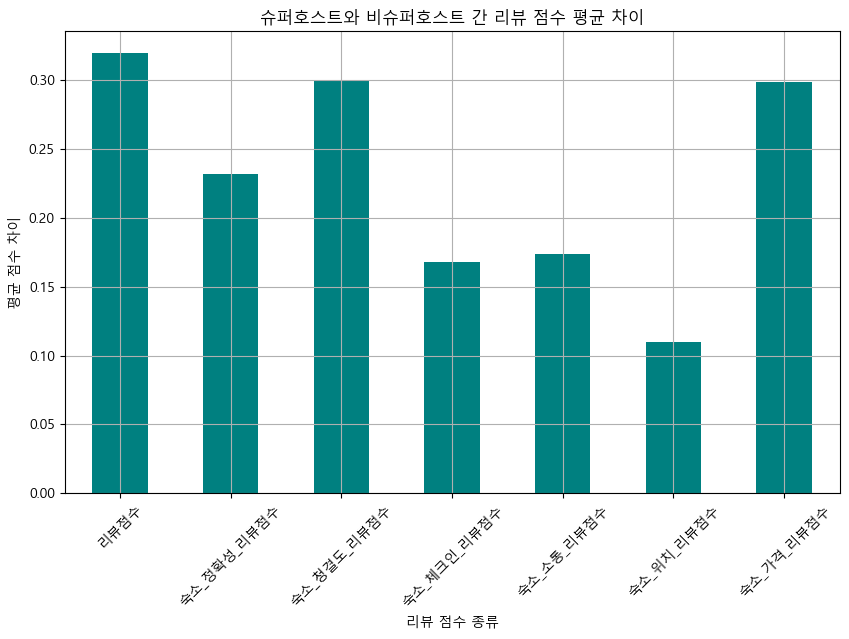

In [42]:
# 슈퍼호스트인 경우와 아닌 경우의 차이 계산
score_diff = review_scores_by_type.diff().iloc[1]

# 차이를 막대 그래프로 표시
score_diff.plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('슈퍼호스트와 비슈퍼호스트 간 리뷰 점수 평균 차이')
plt.xlabel('리뷰 점수 종류')
plt.ylabel('평균 점수 차이')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


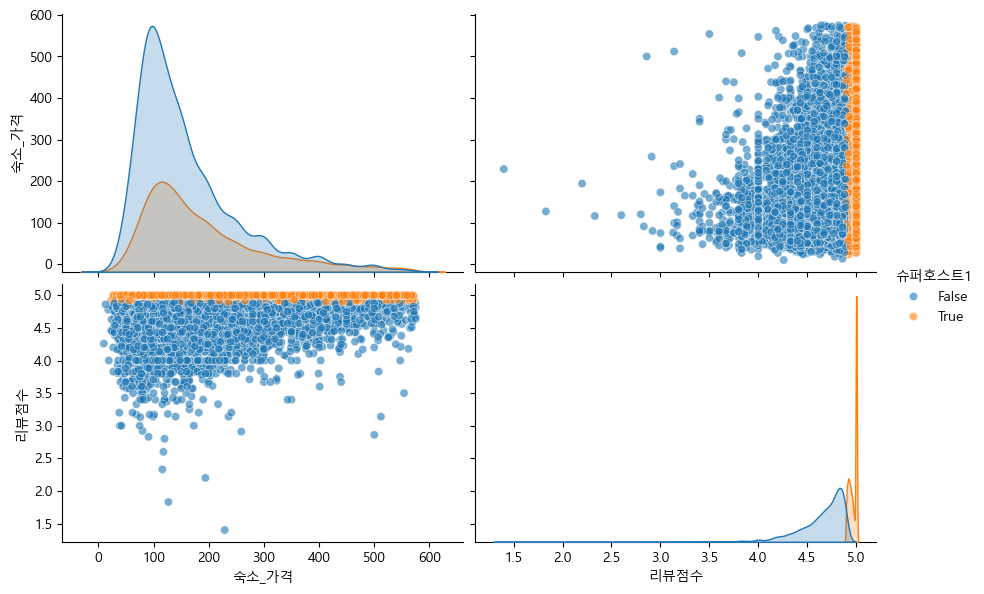

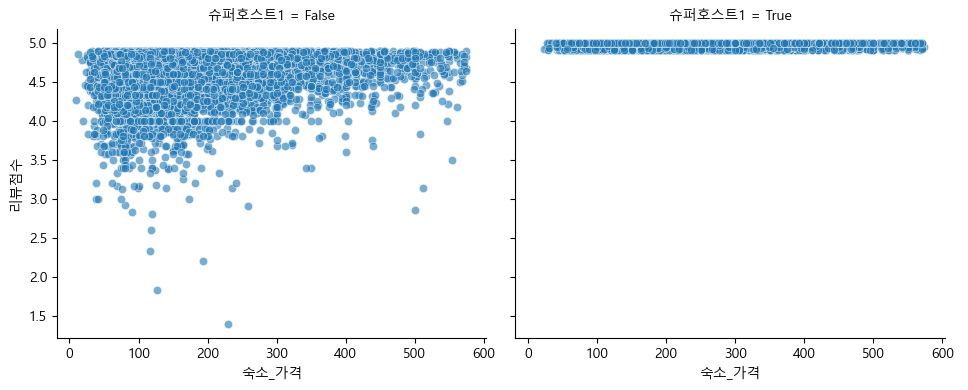

In [43]:
# Seaborn의 Pairplot을 사용하여 슈퍼호스트 여부에 따른 가격과 리뷰 점수의 관계를 그래프로 나타냄
sns.pairplot(df, vars=['숙소_가격', '리뷰점수'], hue='슈퍼호스트1', height=3, aspect=1.5, plot_kws={'alpha':0.6})
plt.show()

# FacetGrid를 사용하여 좀 더 구체적인 조건부 플롯을 만들 수 있음
g = sns.FacetGrid(df, col='슈퍼호스트1', height=4, aspect=1.2)
g.map(sns.scatterplot, '숙소_가격', '리뷰점수', alpha=0.6)
g.add_legend()
plt.show()

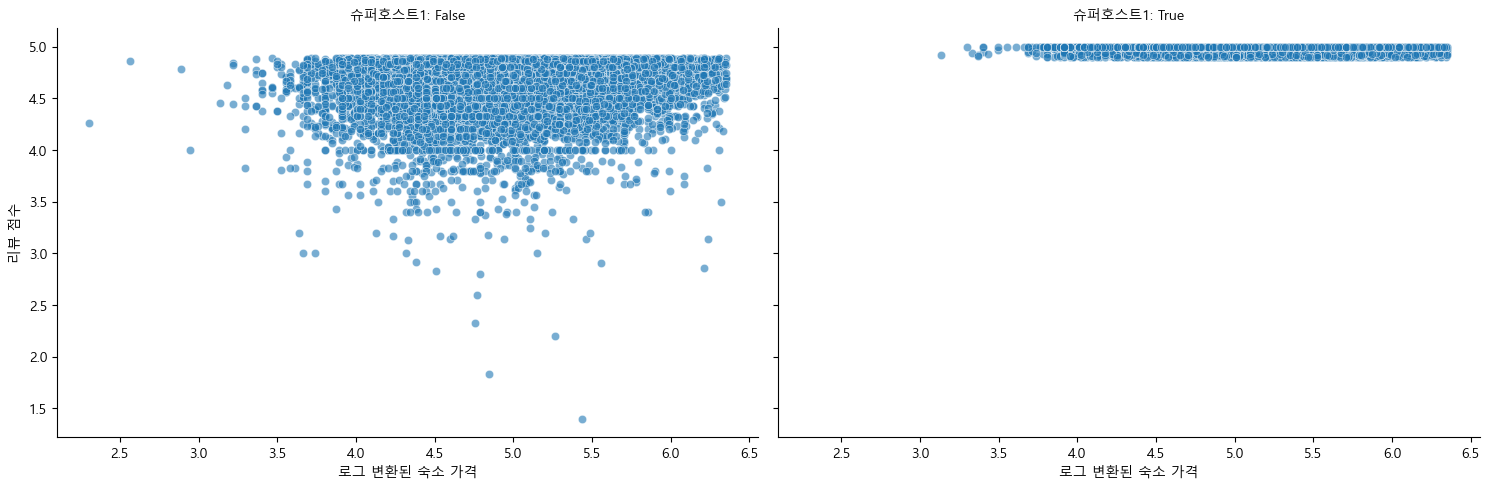

In [44]:
# 조건부 플롯 생성
g = sns.FacetGrid(df, col='슈퍼호스트1', height=5, aspect=1.5)
g.map(sns.scatterplot, '로그_숙소_가격', '리뷰점수', alpha=0.6)

# 그래프 제목 및 레이블 설정
g.set_titles("슈퍼호스트1: {col_name}")
g.set_axis_labels("로그 변환된 숙소 가격", "리뷰 점수")

# 플롯 표시
plt.show()


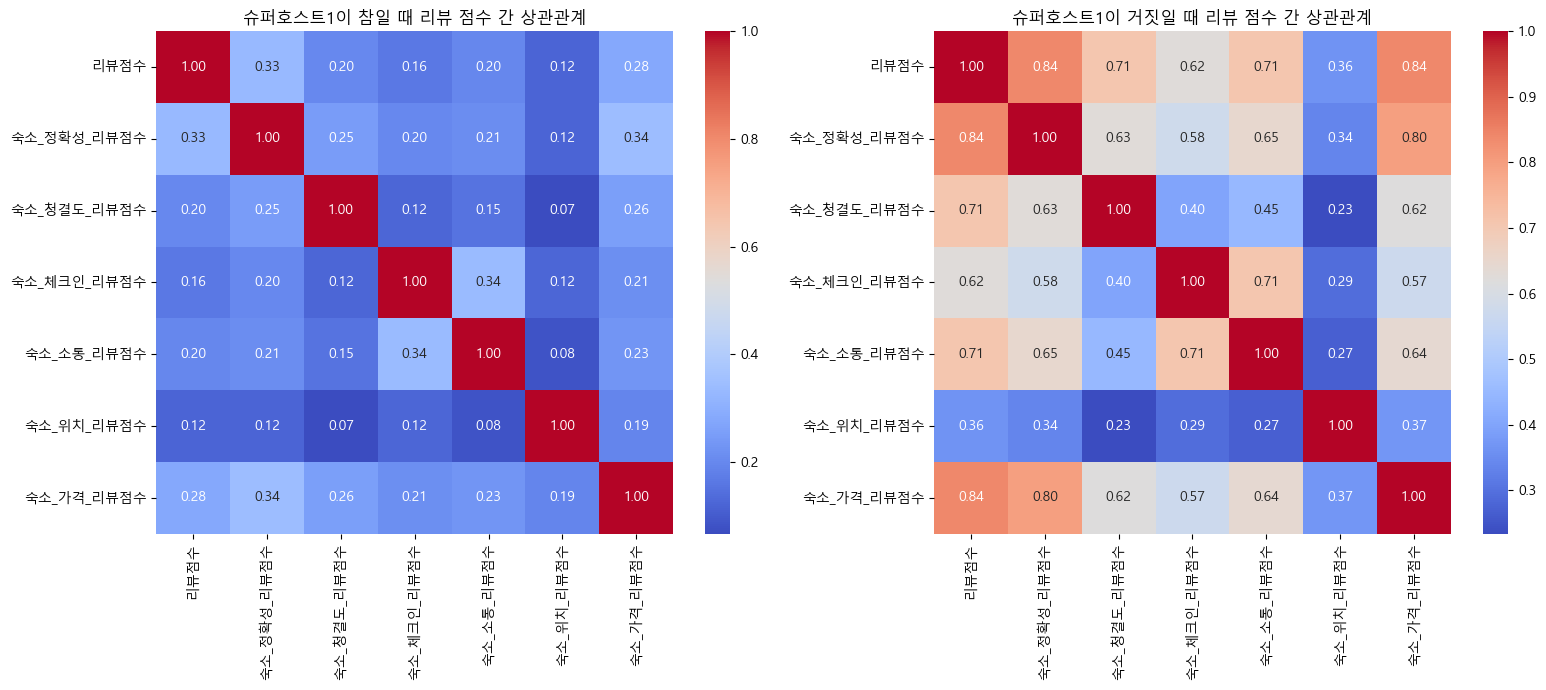

In [45]:
# 관련 리뷰 점수 컬럼 선택
review_scores_data_true = df[df['슈퍼호스트1'] == True][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

review_scores_data_false = df[df['슈퍼호스트1'] == False][[
    '리뷰점수', '숙소_정확성_리뷰점수', '숙소_청결도_리뷰점수', 
    '숙소_체크인_리뷰점수', '숙소_소통_리뷰점수', 
    '숙소_위치_리뷰점수', '숙소_가격_리뷰점수'
]]

# 상관계수 계산
correlation_matrix_true = review_scores_data_true.corr()
correlation_matrix_false = review_scores_data_false.corr()

# 히트맵 생성
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)  # 첫 번째 히트맵
sns.heatmap(correlation_matrix_true, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 참일 때 리뷰 점수 간 상관관계')

plt.subplot(1, 2, 2)  # 두 번째 히트맵
sns.heatmap(correlation_matrix_false, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('슈퍼호스트1이 거짓일 때 리뷰 점수 간 상관관계')

plt.tight_layout()
plt.show()


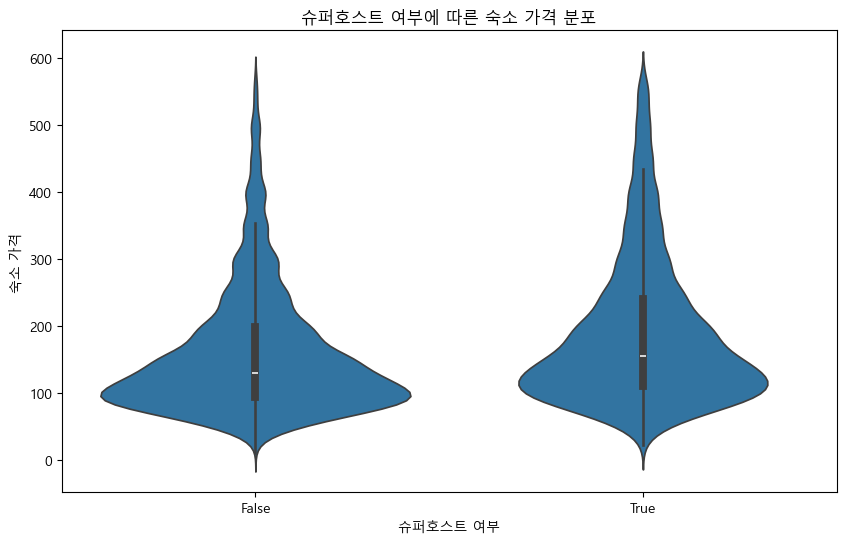

In [46]:
# 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x='슈퍼호스트1', y='숙소_가격', data=df)
plt.title('슈퍼호스트 여부에 따른 숙소 가격 분포')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('숙소 가격')
plt.show()


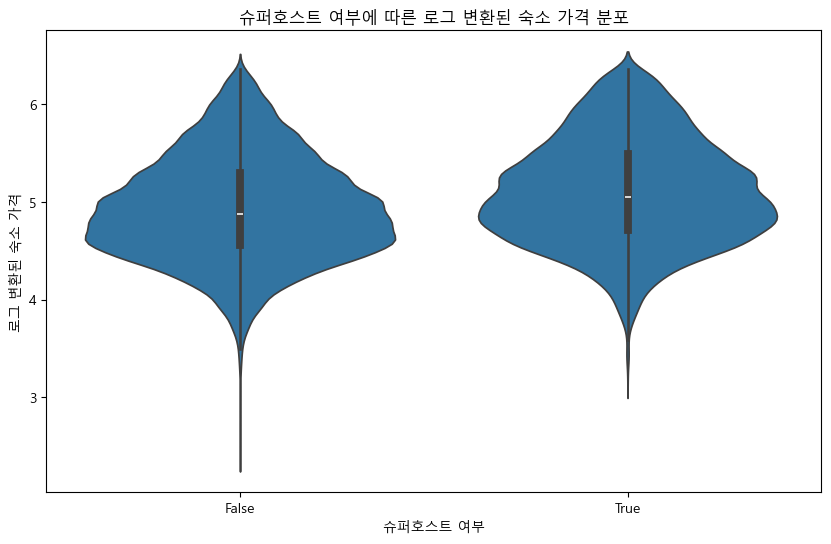

In [47]:
# 숙소 가격에 로그 변환 적용 (0 이상 가격에만 적용)
df['로그_숙소_가격'] = np.log1p(df['숙소_가격'])

# 로그 변환된 가격을 사용하여 바이올린 플롯 생성
plt.figure(figsize=(10, 6))
sns.violinplot(x='슈퍼호스트1', y='로그_숙소_가격', data=df)
plt.title('슈퍼호스트 여부에 따른 로그 변환된 숙소 가격 분포')
plt.xlabel('슈퍼호스트 여부')
plt.ylabel('로그 변환된 숙소 가격')
plt.show()


In [48]:
from scipy.stats import mannwhitneyu

# 슈퍼호스트와 비슈퍼호스트의 가격 데이터 추출
superhost_prices = df[df['슈퍼호스트1'] == True]['숙소_가격']
nonsuperhost_prices = df[df['슈퍼호스트1'] == False]['숙소_가격']

# Mann-Whitney U 테스트 수행
u_stat, p_value = mannwhitneyu(superhost_prices, nonsuperhost_prices, alternative='two-sided')

print("Mann-Whitney U 통계량:", u_stat)
print("P-값:", p_value)


Mann-Whitney U 통계량: 66332361.0
P-값: 7.771786648003025e-107


In [49]:
# 슈퍼호스트 숙소의 가격 중앙값
superhost_median = df[df['슈퍼호스트1'] == True]['숙소_가격'].median()

# 비슈퍼호스트 숙소의 가격 중앙값
nonsuperhost_median = df[df['슈퍼호스트1'] == False]['숙소_가격'].median()

print("슈퍼호스트 숙소 가격 중앙값:", superhost_median)
print("비슈퍼호스트 숙소 가격 중앙값:", nonsuperhost_median)


슈퍼호스트 숙소 가격 중앙값: 155.0
비슈퍼호스트 숙소 가격 중앙값: 130.0


# 리뷰점수 숙소_지역, 숙소_유형
- 리뷰 점수와 숙소_지역과 관계가 있음
- 리뷰 점수와 숙소_유형과 관계 없음

In [50]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# OLS 모델 설정
# C() 함수는 범주형 변수임을 명시합니다.
model = ols('리뷰점수 ~ C(숙소_지역) + C(숙소_유형)', data=df).fit()

# ANOVA 테이블 생성
anova_results = sm.stats.anova_lm(model, typ=2)

# 결과 출력
print(anova_results)


               sum_sq       df          F        PR(>F)
C(숙소_지역)    13.725701     19.0  11.550770  6.895447e-36
C(숙소_유형)     0.171009      1.0   2.734323  9.822688e-02
Residual  1427.890582  22831.0        NaN           NaN


In [51]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터셋 준비
data = df[['리뷰점수', '숙소_가격', '숙소_위치_리뷰점수', '숙소_청결도_리뷰점수']]

# 결측치 처리
data = data.dropna()

# 데이터 표준화
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# PCA 실행
pca = PCA(n_components=2)  # 주성분을 2개로 설정
principalComponents = pca.fit_transform(data_scaled)

# 주성분 DataFrame 생성
principalDf = pd.DataFrame(data=principalComponents, columns=['주성분 1', '주성분 2'])

# 설명된 분산 비율
print("설명된 분산 비율:", pca.explained_variance_ratio_)


설명된 분산 비율: [0.52507051 0.23863212]


In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_scaled)  # data_scaled는 표준화된 데이터
print("주성분 (고유벡터):\n", pca.components_)  # 각 주성분의 방향을 나타내는 고유벡터
print("설명된 분산 (고유값):\n", pca.explained_variance_)  # 각 주성분의 고유값


주성분 (고유벡터):
 [[-0.61733426 -0.25521038 -0.44802459 -0.59417173]
 [-0.26889085  0.90246645  0.20764706 -0.2648296 ]]
설명된 분산 (고유값):
 [2.10037397 0.95457025]


In [60]:
df[(df['리뷰점수']< 3) ]['url']

34057              https://www.airbnb.com/rooms/46458749
37412              https://www.airbnb.com/rooms/52437860
46482    https://www.airbnb.com/rooms/725817935999497422
46952    https://www.airbnb.com/rooms/736758490338790987
48140    https://www.airbnb.com/rooms/765838245282284558
50519    https://www.airbnb.com/rooms/818087220238840879
63130    https://www.airbnb.com/rooms/964299925080481550
63721    https://www.airbnb.com/rooms/970788437267293789
63986    https://www.airbnb.com/rooms/973085284532642299
64170    https://www.airbnb.com/rooms/973727065954498410
Name: url, dtype: object